In [1]:
import pandas as pd

df = pd.read_csv("data/processed/olist_enhanced_data.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
])


In [2]:
# Target variable: churn risk if review_score <= 2
df = df[df["review_score"].notna()]  # drop missing reviews
df["is_detractor"] = (df["review_score"] <= 2).astype(int)

# Delivery delay
df["delivery_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Select relevant features
model_df = df[[
    "is_detractor", "price", "freight_value", "delivery_days", "product_category_name"
]].dropna()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# One-hot encode category
encoded = pd.get_dummies(model_df["product_category_name"], prefix="cat")
X = pd.concat([model_df[["price", "freight_value", "delivery_days"]], encoded], axis=1)
y = model_df["is_detractor"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     19300
           1       0.72      0.45      0.55      3347

    accuracy                           0.89     22647
   macro avg       0.81      0.71      0.74     22647
weighted avg       0.88      0.89      0.88     22647



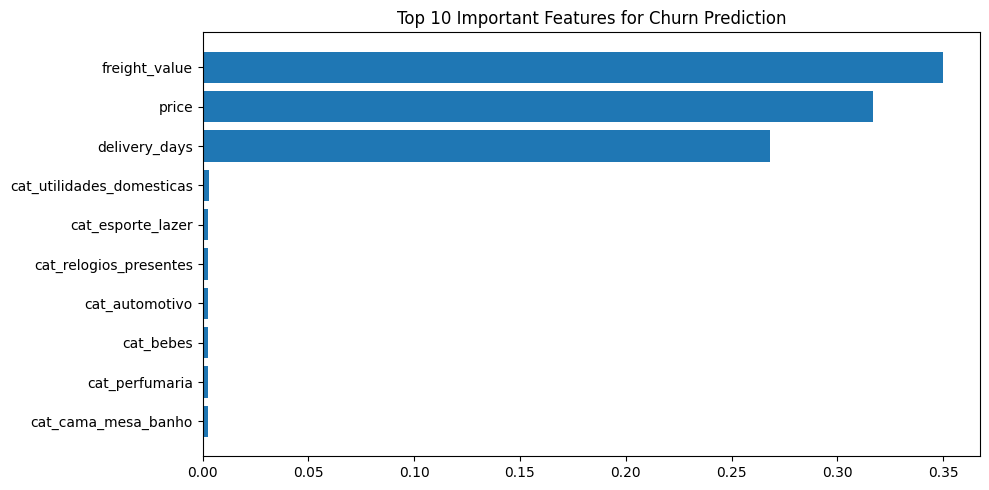

In [5]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
features = X.columns
sorted_idx = importances.argsort()[-10:]  # top 10

plt.figure(figsize=(10, 5))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Top 10 Important Features for Churn Prediction")
plt.tight_layout()
plt.show()
